# Ising Model 
For a graph, $G = (E,V)$, defined by a set of edges, $E$, and vertices, $V$, we want to represent an Ising model, where the edge weights, $w_{ij}$ are given by the spin interactions, i.e., $w_{ij} = J_{ij}$.

Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H} = \sum_{(i,j)\in E}J_{ij} s_is_j$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the sumation runs over all edges in the graph. 
**Note:** As we saw before, this Hamiltonian operator is simple, in that a single `BitString` returns a single energy. This is because the matrix representation of the Hamiltonian operator in the computational basis (i.e., basis of all possible `BitString`'s) is a diagonal matrix. However, most quantum mechanical Hamiltonians will not be diagonal, and in that case applying $H$ to a single `BitString` would generate multiple `BitString`'s.   



# Thermodynamic averages
In the previous notebook, we used the Hamiltonian (which was defined as a graph) to find the lowest "energy" configuration (`BitString`). However, often times we want to compute average values of an observable over all possible configurations. Imagine that you have a bag containing some mixture of `BitString`'s. If we reach into the back and pull out a `BitString` at random, the probability of observing the specific `BitString` $\ket{\alpha}$ will be denoted as $P(\alpha)$. Each possible `BitString` has its own probability. 

Given this situation, what is the average energy in the bag? To answer this, we could just pull out each `BitString`, measure it's energy, add them all up, and divide by the total number of `BitString`s. Or if we knew the probabilty of observing each possible `BitString`, we could equivalently, add up the probabilities times the energy, $E(\alpha)$, of each possible `BitString`:
$$
\left<E\right> = \sum_\alpha P(\alpha)E(\alpha)
$$ 
In this sense, the average energy (or any average quantity) depends on the given probability distribution in the bag. 

While there are an infinite number of possible probability distributions one might interact with, a very common distribution (and the one we will focus on) is the `Gibbs Distribution`, also called the `Boltzmann Distribution`:
$$
P(\alpha) = \frac{e^{-\beta E(\alpha)}}{Z} = \frac{e^{-\beta E(\alpha)}}{\sum_{\alpha'}e^{-\beta E(\alpha')}}
$$
where $\beta$ sometimes has a physical meaning of $\beta = 1/kT$, where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$ and $T$ is the temperature in Kelvin. We generally refer to the normalization constant $Z$ as the partition function. 

This expression, defines the probability of observing a particular configuration of spins, $\alpha$. As you can see, the probability of pulling $\alpha$ out of your bag decays exponentially with increasing energy of $\alpha$, $E(\alpha)$. This expression governs the behavior of the vast majority of physical systems, meaning that in nature at low temperatures, one typically expects to observe the lowest possible configuration of a system.

If the population (e.g., the bag of `BitString`s) is known to form a Boltzmann distribution, the expectation value of any quantity, `A`, can be defined as:
$$
\left<A\right> = \frac{\sum_\alpha e^{-\beta E(\alpha)}A(\alpha)}{Z}.
$$

# Properties

For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to exactly obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases.

The expectation values we will compute in this notebook are
\begin{align}
\text{Energy} &= \left<E\right> \\
\text{Magnetization} &= \left<M\right> \\
\text{Heat Capacity} &= \left(\left<E^2\right>-\left<E\right>^2\right)T^{-2} \\
\text{Magnetic Susceptibility} &= \left(\left<M^2\right>-\left<M\right>^2\right)T^{-1}
\end{align}

# Expectation values for Boltzmann Distribution

In this notebook, we will write code to compute the expectation values of a few different properties, at a given temperature. We will then see how these change with temperature. 

## Load packages

In [96]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
random.seed(2)

## Create a graph that defines the Ising interactions

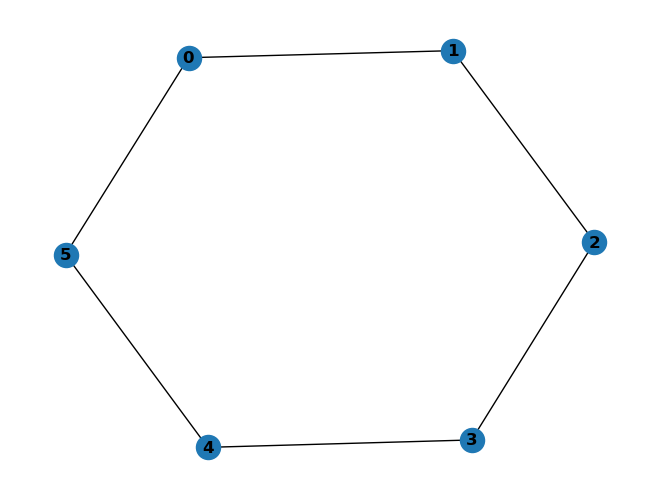

In [97]:
N = 6
Jval = 2.0
G = nx.Graph()
G.add_nodes_from([i for i in range(N)])
G.add_edges_from([(i,(i+1)% G.number_of_nodes() ) for i in range(N)])
for e in G.edges:
    G.edges[e]['weight'] = Jval

# Now Draw the graph. 
plt.figure(1)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

## Add your BitString class here:

In [98]:
class BitString:
    """
    Simple class to implement a config of bits
    """
    def __init__(self, N):
        self.N = N
        self.config = np.zeros(N, dtype=int) 

    def __repr__(self):
        #Creating an empty string to add the array self.config to
        str1 = ""

        #for loop to add a string version of each entry from the array to the string
        for entry in self.config:
            str1 += str(entry)

        #section of method to define the new string
        return str1

    def __eq__(self, other): 
        str_sel = ""
        str_oth = ""
        for entry in self.config: #for loop to convert arrays to strings
            str_sel += str(entry)
        for entry in other.config:
            str_oth +=str(entry)

        if str_sel == str_oth: #compare the strings
            return True #defining the bolean value of equivalance here
        return False
    
    def __len__(self):
        #needed to establish the return value to be the len() of self.config
        return len(self.config)

    def on(self):
        #make a variable to save the number of 1's
        on_bit = 0
        for i in range(len(self.config)): # for loop to to increase on_count for each entry = 1
            if self.config[i] == 1:
                on_bit += 1
        #need to return for the function to actually do something
        return on_bit

    def off(self):
        #make a variable to save the number of 0's
        off_bit = 0
        for i in range(len(self.config)): # for loop to to increase off_count for each entry = 1
            if self.config[i] == 0:
                off_bit += 1
        return off_bit
    
    def flip_site(self,i):
        #create a for loop to switch the designated entry
        # if the ith entry of array is 0, set ith entry to 1
        if self.config[i] == 0:
            self.config[i] = 1
        #else set entry to 0
        else:
            self.config[i] = 0
    
    def int(self): #converts bindary to decimal
        count = 0
        int_bit = 0

        for i in range(len(self.config), 0, -1): #for loop to add 2^count of each binary digit
            int_bit += (int(self.config[i-1]) * (2**count)) 
            count += 1

            if count > len(self.config): #saftey loop
                return "loop error :("
        
        return int_bit
 

    def set_config(self, s:list[int]):
        #set original array equal to new one
        self.config = s
        
    def set_int_config(self, dec:int):
        str_len = len(self.config) #save length of bit array
        self.config = np.zeros(str_len, dtype=int) #set bit array to zero

        dec_int = dec #track variable division and act as while loop counter
        dec_rem = 0
        count = 0 #counter in while loop to determine string position

        while dec_int != 0:
            dec_rem = dec_int % 2 # get remainder of decimal number, convert to bin w/if else
            if dec_rem == 1: #if-else to add numbers to end of string
                self.config[str_len - count -1] = 1
            else:
                self.config[str_len - count -1] = 0

            count += 1
            dec_int = dec_int // 2 #division at end of loop to help end early 
            #eventually will go to the value zero
        

## Write your energy function here:

In [99]:
def energy(bs: BitString, G: nx.Graph):
    """Compute energy of configuration, `bs`

        .. math::
            E = \\left<\\hat{H}\\right>

    Parameters
    ----------
    bs   : Bitstring
        input configuration
    G    : Graph
        input graph defining the Hamiltonian
    Returns
    -------
    energy  : float
        Energy of the input configuration
    """
    # Using bitstring to represent up or down spin of each of the given points. Connected points (points w/edges) add/subtract energy depednign on their relative spin
    energy_value = float(0) #float value to save energy
    for (i,j,k) in G.edges(data = True): #for all points with a connecting edge
        if bs.config[i] == bs.config[j]:
            energy_value += k['weight'] #increase energy from matching spin
        else:
            energy_value -= k['weight'] #decrease energy from matching spin
        #G.edges has three indexes, the third is dictionary. By calling the string 'weight' in the dictionary, I pull the assigned weight value that is 1.0
            
    return energy_value


## Write function to compute the thermodynamic averages

In [100]:
def compute_average_values(bs:BitString, G: nx.Graph, T: float):
    """
    Compute the average value of Energy, Magnetization, 
    Heat Capacity, and Magnetic Susceptibility 

        .. math::
            E = \\left<\\hat{H}\\right>

    Parameters
    ----------
    bs   : Bitstring
        input configuration
    G    : Graph
        input graph defining the Hamiltonian
    T    : float
        temperature of the system
    Returns
    -------
    energy  : float
    magnetization  : float
    heat capacity  : float
    magnetic susceptibility  : float
    """
    # The average value can be found by computing the configuratoin, times the probability
    # Find the expecation values

    # All initilialized variables
    con_en = 0 #the energy of the given configuation
    magn = 0 # The magnetization of the configuration, up - down spins
    kb = 1 # Boltzman constant simplified, 1.38064e-23 J/K actual
    factor = 0 # e^-B*E(a), factor in probability function
    Z = 0.0 # The normalization factor of probability
    prob = 0 # The probability function for the given configuration

    E = 0 # The average energy
    M = 0 # The average magnetization
    HC = 0.0 # The average heat capacity
    HC_var = 0.0 # Variable to calculate HC
    MS = 0.0 # The average magnetic susceptibility
    MS_var = 0.0 # Variable to calculate MS

    # Calculate Z before main loop
    for i in range(2 ** bs.N): #from 0 to 2^N, where N is derived from bs function
        bs.set_int_config(i) # Set the current bitstring to the given loop
        con_en = energy(bs, G)
        Z += np.exp(-con_en/((kb) * T))

    for i in range(2 ** bs.N): # big for loop for all possible calculations
        # Set variables for the given configuration
        bs.set_int_config(i) # Set the current bitstring to the given loop
        con_en = energy(bs, G)
        factor = np.exp(-con_en/((kb) * T))

        # Calculate probability for the given config
        prob = factor / Z

        # Magnetization calculations, using built in 1/0 count in bitstring class
        magn = bs.on() - bs.off()

        # Calculate Energy & M
        E += con_en * prob
        M += magn * prob

        # The other factors to calculate HC and MS
        HC_var += (con_en ** 2) * prob
        MS_var += (magn ** 2) * prob

    # Calculate HC and MS using the expectation values from the loop
    HC = ((HC_var - (E ** 2)) / (T ** 2))
    MS = ((MS_var - (M ** 2)) / (T ** 1))

    bs.set_int_config(1)
    print(str(bs.on()) + str(bs.off()))

    return E, M, HC, MS

In [101]:
# Define a new configuration instance for a 6-site lattice
conf = BitString(N)

# Compute the average values for Temperature = 1
E, M, HC, MS = compute_average_values(conf, G, 1)


print(" E  = %12.8f" %E)
print(" M  = %12.8f" %M)
print(" HC = %12.8f" %HC)
print(" MS = %12.8f" %MS)

assert(np.isclose(E,  -11.95991923))
assert(np.isclose(M,   -0.00000000))
assert(np.isclose(HC,   0.31925472))
assert(np.isclose(MS,   0.01202961))


15
 E  = -11.95991923
 M  =   0.00000000
 HC =   0.31925472
 MS =   0.01202961


# Properties vs Temperature (exact)

 Number of configurations:  64
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
 Critical Temperature:   4.30000000 
     E:   -5.36028889
     M:   -0.00000000
     HC:   1.18893365
     MS:   0.54308001
 Critical Temperature:   2.20000000
 E = -10.21957820 @ T =   2.00000000


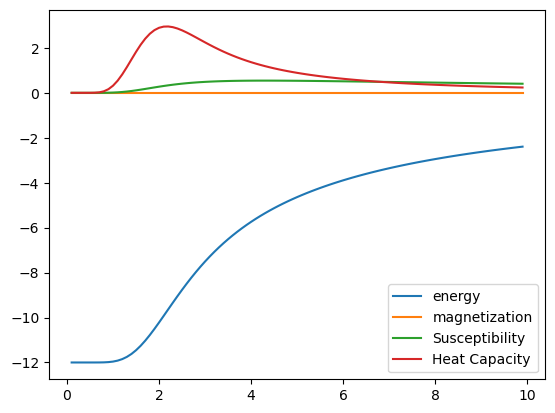

In [102]:
# Initialize lists that we will fill with the property vs. temperature data
e_list = []
e2_list = []
m_list = []
m2_list = []
T_list = []

# Create BitString
conf = BitString(N)
print(" Number of configurations: ", 2**len(conf))


for Ti in range(1,100):
    T = .1*Ti
    
    E, M, HC, MS = compute_average_values(conf, G, T)
    
    e_list.append(E)
    m_list.append(M)
    e2_list.append(HC)
    m2_list.append(MS)
    T_list.append(T)


plt.plot(T_list, e_list, label="energy");
plt.plot(T_list, m_list, label="magnetization");
plt.plot(T_list, m2_list, label="Susceptibility");
plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

Tc_ind = np.argmax(m2_list)
print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
print("     E:  %12.8f" %(e_list[Tc_ind]))
print("     M:  %12.8f" %(m_list[Tc_ind]))
print("     HC: %12.8f" %(e2_list[Tc_ind]))
print("     MS: %12.8f" %(m2_list[Tc_ind]))
Tc2 = T_list[np.argmax(e2_list)]
print(" Critical Temperature: %12.8f" %(Tc2))

print(" E = %12.8f @ T = %12.8f"% (e_list[T_list.index(2.00)], 2.0))


----
